In [1]:
import pandas as pd
import numpy as np
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
import nltk
nltk.download('stopwords')
st_words= set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHRUTI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df_train=pd.read_csv("C:/Users/SHRUTI/OneDrive/Desktop/MLT DATASETS/Corona_NLP_train.csv", encoding='latin-1')
df_test=pd.read_csv("C:/Users/SHRUTI/OneDrive/Desktop/MLT DATASETS/Corona_NLP_test.csv", encoding='latin-1')
   

In [7]:
df_train.head()
df_train.shape

(41157, 6)

In [8]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


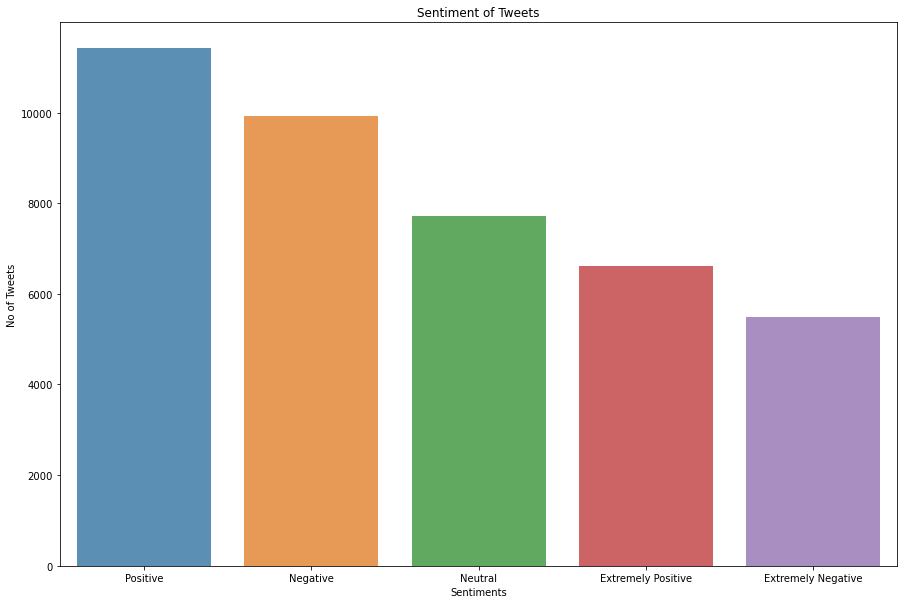

In [9]:
Sentiment_counts = df_train["Sentiment"].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(Sentiment_counts.index, Sentiment_counts.values, alpha=0.8)
plt.title('Sentiment of Tweets')
plt.ylabel('No of Tweets')
plt.xlabel('Sentiments')
plt.show()

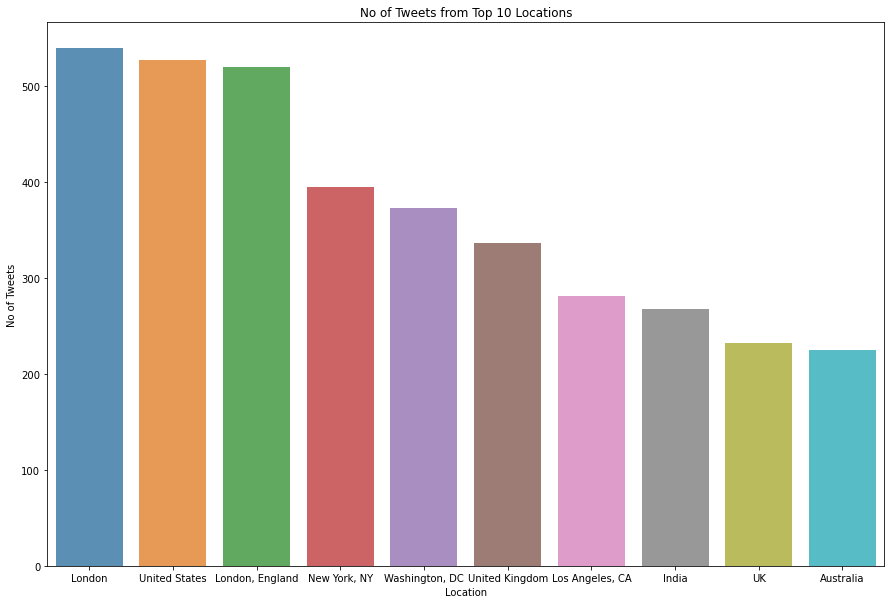

In [10]:
counts = df_train["Location"].value_counts()[:10]
plt.figure(figsize=(15,10))
sns.barplot(counts.index, counts.values, alpha=0.8)
plt.title('No of Tweets from Top 10 Locations')
plt.ylabel('No of Tweets')
plt.xlabel('Location')
plt.show()

In [9]:
df_train['Sentiment'] = df_train['Sentiment'].str.replace('Extremely Positive', 'Positive')
df_train['Sentiment'] = df_train['Sentiment'].str.replace('Extremely Negative', 'Negative')
df_train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [10]:
df_test['Sentiment'] = df_test['Sentiment'].str.replace('Extremely Positive', 'Positive')
df_test['Sentiment'] = df_test['Sentiment'].str.replace('Extremely Negative', 'Negative')
df_test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative


In [11]:
df_test.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)


In [12]:
df_train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)


In [13]:
def prep_tweet(tweet):
    tweet=tweet.lower() #casing
    
    tweet=re.sub(r"https\S+|www\S+|https\S+"," ", tweet, flags=re.MULTILINE) #remove any urls
    tweet=tweet.translate(str.maketrans(" "," ",string.punctuation)) #remove any punctuations
    tweet=re.sub(r'\@\w+|\#'," ", tweet) #remove @ #
    
    #remove stopwords
    tweet_tokens= word_tokenize(tweet)
    filtered_words=[word for word in tweet_tokens if word not in st_words]
    
    #stemming using porterstemmer
    pstem=PorterStemmer()
    stemmed_words=[pstem.stem(w) for w in filtered_words]
    
    #lemmatizing
    lemm = WordNetLemmatizer()
    lem_words=[lemm.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(lem_words)

In [14]:
df_train["OriginalTweet"]=df_train["OriginalTweet"].apply(prep_tweet)

In [15]:
df_test["OriginalTweet"]=df_test["OriginalTweet"].apply(prep_tweet)

In [16]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


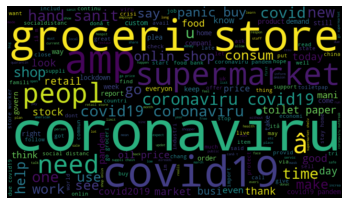

In [19]:
#plotting wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

aWrds= ' '.join([tweets for tweets in df_train['OriginalTweet']])
wordCloud=WordCloud(width = 700, height=400, random_state= 21, max_font_size=119).generate(aWrds)
                                                                                           
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

#grocery coronavirus covid19 appeared alot

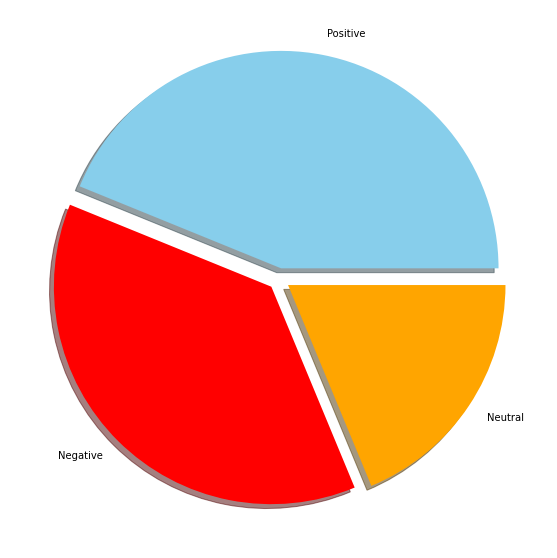

In [20]:
y = df_train['Sentiment'].value_counts()
lab = ["Positive", "Negative", "Neutral"]
exp = [0.05, 0.05, 0.05]
col= ['skyblue','red','orange']
plt.figure(figsize=(10,10))
plt.pie(y, labels = lab, explode = exp, colors = col, shadow = True)
plt.show() 

In [21]:
df_train['Sentiment'] = df_train['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Neutral':0, 'Positive':1, 'Negative':2})
X_train=df_train["OriginalTweet"]
Y_train=df_train["Sentiment"]
X_test=df_test["OriginalTweet"]
Y_test=df_test["Sentiment"]

In [22]:
vectorizer= TfidfVectorizer()
X1_train=vectorizer.fit_transform(X_train)
X1_test=vectorizer.transform(X_test)

In [23]:
model=LogisticRegression()
model.fit(X1_train,Y_train,)

LogisticRegression()

In [24]:
predLR=model.predict(X1_test)

In [25]:
print(accuracy_score(Y_test,predLR))

0.7830437072143234


In [26]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,predLR))


              precision    recall  f1-score   support

           0       0.72      0.59      0.64       619
           1       0.78      0.85      0.82      1546
           2       0.80      0.79      0.80      1633

    accuracy                           0.78      3798
   macro avg       0.77      0.74      0.75      3798
weighted avg       0.78      0.78      0.78      3798



In [27]:
from sklearn import naive_bayes
model1=naive_bayes.MultinomialNB()
model1.fit(X1_train,Y_train)

MultinomialNB()

In [28]:
predNB=model1.predict(X1_test)

In [29]:
print(accuracy_score(Y_test,predNB))

0.6303317535545023


In [30]:
print(classification_report(Y_test,predNB))

              precision    recall  f1-score   support

           0       0.80      0.01      0.01       619
           1       0.56      0.89      0.69      1546
           2       0.76      0.62      0.68      1633

    accuracy                           0.63      3798
   macro avg       0.71      0.51      0.46      3798
weighted avg       0.69      0.63      0.58      3798



In [31]:
from sklearn.ensemble import GradientBoostingClassifier
GBC=GradientBoostingClassifier(random_state=0)
GBC.fit(X1_train,Y_train)

GradientBoostingClassifier(random_state=0)

In [32]:
predGbc=GBC.predict(X1_test)

In [33]:
print(accuracy_score(Y_test,predGbc))

0.6614007372301212


In [34]:
print(classification_report(Y_test,predGbc))

              precision    recall  f1-score   support

           0       0.57      0.43      0.49       619
           1       0.61      0.81      0.70      1546
           2       0.78      0.60      0.68      1633

    accuracy                           0.66      3798
   macro avg       0.65      0.62      0.62      3798
weighted avg       0.68      0.66      0.66      3798



In [35]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(random_state=0)
RFC.fit(X1_train,Y_train)

RandomForestClassifier(random_state=0)

In [36]:
predrfc=RFC.predict(X1_test)

In [37]:
print(accuracy_score(Y_test,predrfc))

0.724855186940495


In [38]:
print(classification_report(Y_test,predrfc))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       619
           1       0.72      0.80      0.76      1546
           2       0.77      0.70      0.74      1633

    accuracy                           0.72      3798
   macro avg       0.71      0.70      0.70      3798
weighted avg       0.73      0.72      0.72      3798



In [39]:
from sklearn.tree import DecisionTreeClassifier
DTC=DecisionTreeClassifier(random_state=0)
DTC.fit(X1_train,Y_train)

DecisionTreeClassifier(random_state=0)

In [40]:
preddtc=DTC.predict(X1_test)

In [41]:
print(accuracy_score(Y_test,preddtc))

0.617693522906793


In [42]:
print(classification_report(Y_test,preddtc))

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       619
           1       0.64      0.66      0.65      1546
           2       0.65      0.60      0.62      1633

    accuracy                           0.62      3798
   macro avg       0.60      0.61      0.60      3798
weighted avg       0.62      0.62      0.62      3798



In [43]:
#Using Keras

In [17]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM,GRU, Embedding, Dropout
from keras.layers import GlobalMaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer=Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(df_train['OriginalTweet'].values)

X_train=tokenizer.texts_to_sequences(df_train['OriginalTweet'].values)
X_train=pad_sequences(X_train,maxlen=30)
#X_train[:5]

XTest = tokenizer.texts_to_sequences(df_test['OriginalTweet'].values)
XTest = pad_sequences(XTest, maxlen=30)

In [19]:
X_train.shape, XTest.shape

((41157, 30), (3798, 30))

In [20]:
#usingRNN

In [21]:
model=Sequential()
model.add(Embedding(5000,256,input_length=X_train.shape[1])) #embedding layer 
model.add(Dropout(0.3))#dropout layrs
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [22]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,856,707
Trainable params: 2,856,707
Non-trainable params: 0
______________________________________________

In [23]:
y_train=pd.get_dummies(df_train['Sentiment']).values
y_test=pd.get_dummies(df_test['Sentiment']).values

In [24]:
batch_size=64
epochs=6
model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/6
644/644 - 1104s - loss: 0.6593 - accuracy: 0.7243
Epoch 2/6
644/644 - 1145s - loss: 0.4568 - accuracy: 0.8414
Epoch 3/6
644/644 - 1072s - loss: 0.4171 - accuracy: 0.8560
Epoch 4/6
644/644 - 1146s - loss: 0.3844 - accuracy: 0.8681
Epoch 5/6
644/644 - 826s - loss: 0.3477 - accuracy: 0.8817
Epoch 6/6
644/644 - 642s - loss: 0.3151 - accuracy: 0.8928


In [25]:
model.evaluate(XTest,y_test)


119/119 [==============================] - 13s 102ms/step - loss: 0.5413 - accuracy: 0.8170


[0.5413084626197815, 0.8170089721679688]

In [26]:
#using GRUs

In [27]:
Model_GRU = Sequential()
Model_GRU.add(Embedding(5000,256, input_length=X_train.shape[1]))
Model_GRU.add(GRU(100))
Model_GRU.add(Dense(3, activation='softmax'))
Model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
Model_GRU.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 256)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 100)               107400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 1,387,703
Trainable params: 1,387,703
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size=64
epochs=6
Model_GRU.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/6
644/644 - 37s - loss: 0.6103 - accuracy: 0.7557
Epoch 2/6
644/644 - 38s - loss: 0.4347 - accuracy: 0.8487
Epoch 3/6
644/644 - 33s - loss: 0.3800 - accuracy: 0.8684
Epoch 4/6
644/644 - 34s - loss: 0.3262 - accuracy: 0.8867
Epoch 5/6
644/644 - 34s - loss: 0.2712 - accuracy: 0.9056
Epoch 6/6
644/644 - 33s - loss: 0.2179 - accuracy: 0.9269


In [29]:
Model_GRU.evaluate(XTest,y_test)

119/119 [==============================] - 2s 8ms/step - loss: 0.6773 - accuracy: 0.7830


[0.6772704720497131, 0.7830436825752258]

In [30]:
#using BI-LSTMS

In [31]:
BILSTMModel = Sequential()
BILSTMModel.add(Embedding(5000,256, input_length=X_train.shape[1]))
BILSTMModel.add(Bidirectional(LSTM(100, return_sequences=True)))
BILSTMModel.add(GlobalMaxPooling1D())
BILSTMModel.add(Dense(3, activation='softmax'))
BILSTMModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
BILSTMModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 256)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 200)           285600    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 1,566,203
Trainable params: 1,566,203
Non-trainable params: 0
_________________________________________________________________


In [32]:
batch_size=64
epochs=6
BILSTMModel.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/6
644/644 - 62s - loss: 0.5971 - accuracy: 0.7629
Epoch 2/6
644/644 - 55s - loss: 0.4308 - accuracy: 0.8499
Epoch 3/6
644/644 - 61s - loss: 0.3842 - accuracy: 0.8675
Epoch 4/6
644/644 - 58s - loss: 0.3346 - accuracy: 0.8858
Epoch 5/6
644/644 - 57s - loss: 0.2763 - accuracy: 0.9072
Epoch 6/6
644/644 - 61s - loss: 0.2158 - accuracy: 0.9288


In [33]:
BILSTMModel.evaluate(XTest,y_test)

119/119 [==============================] - 2s 13ms/step - loss: 0.6357 - accuracy: 0.8044


[0.6357396245002747, 0.8043707013130188]